In [ ]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import time
import os
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import euclidean, pdist
from sklearn.preprocessing import QuantileTransformer
import scipy.signal

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

In [2]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
timecols = ['weekday', 'hourminute']

In [3]:
data = pd.read_excel(rootPath+'Testcase_dataset-IBPEM.xlsx', index_col=None)
print(data.shape)
print(data.dtypes)
display(data.head())

(17719, 4)
Date                      object
Time                      object
CWRT_syth                float64
HLI Entering CHW Temp    float64
dtype: object


,Date,Time,CWRT_syth,HLI Entering CHW Temp
0,2019-01-13,0000h,31.090000,NaN
1,2019-01-13,0005h,31.106000,NaN
2,2019-01-13,0010h,31.129999,10.6
3,2019-01-13,0015h,31.146000,NaN
4,2019-01-13,0020h,31.170000,NaN


In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data['DateTime'] = (data['Date'] + ' ' + data['Time'].apply(lambda x: x[:2]+':'+x[2:-1]+':00')).apply(dateparse)
data = data.set_index('DateTime')
print(data.shape)
print(data.dtypes)
print(min(data.index), max(data.index))
display(data.head())

display(data.describe())

(17719, 4)
Date                      object
Time                      object
CWRT_syth                float64
HLI Entering CHW Temp    float64
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp
DateTime,,,,
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN


,CWRT_syth,HLI Entering CHW Temp
count,17615.000000,5868.000000
mean,34.761378,13.929772
std,3.042954,1.861147
min,0.000000,9.100000
25%,32.669998,13.000000
50%,35.330001,13.500000
75%,36.368999,14.800000
max,50.804002,23.700001


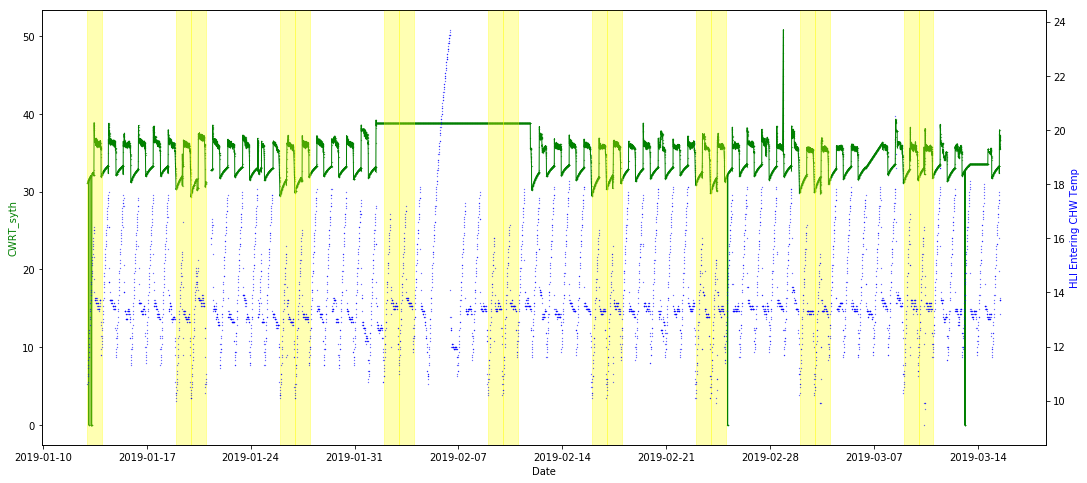

In [5]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data.index, data['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data.index, data['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data.index.to_frame()
tmp['wkday'] = data.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    
plt.show()

### find period

In [6]:
def getautocorrelation(pds_, corr_cutoff=50, pctpdsuse=0.7):
    pds = pds_.dropna().copy()
    nts = int(len(pds)*0.70)
    autocorr = [pds.shift(i).corr(pds) for i in range(nts)]
    autocorr_pds = pd.Series(autocorr, index=pds.index[:len(autocorr)])
    cutoff = np.percentile(autocorr, corr_cutoff)
    autocorr_pds_highscore = autocorr_pds[autocorr_pds>cutoff].to_frame()
    autocorr_pds_highscore['gap'] = pd.Series(
        autocorr_pds_highscore.index, index=autocorr_pds_highscore.index) - pd.Series(
        autocorr_pds_highscore.index, index=autocorr_pds_highscore.index).shift(1)
    gaps = autocorr_pds_highscore['gap'].value_counts().index[1:]
    tmp = autocorr_pds_highscore[autocorr_pds_highscore['gap'].isin(gaps)].copy()
    tmp['half_gap'] = tmp['gap']/2
    tmp['point'] = pd.Series(tmp.index, index=tmp.index) + tmp['half_gap']
    tmp['point_diff'] = tmp['point']-tmp['point'].shift(1)
    return tmp['point_diff'].median()
       

In [7]:
periods = {}

for col in maincols:
    tmp = data[col]
    #tmp = data[col].interpolate(method='polynomial', order=1) 
    periods[col] = getautocorrelation(tmp, corr_cutoff=50)
    
periods    

{'CWRT_syth': Timedelta('0 days 23:50:00'),
 'HLI Entering CHW Temp': Timedelta('0 days 23:45:00')}

## <font color='purple'>Anomaly Type 1: Single Feature - inconsistent time gap</font>
- <font color='grey'>look at the entire dataframe, fill missed timestamp, if any</font>
- <font color='grey'>flag wrong time gap</font>

In [8]:
def findcorrectgap(pds, pctthreshold):
    gapcnt = pds['gap'].value_counts(ascending=False)
    if gapcnt.iloc[0] / gapcnt.sum() > pctthreshold:
        correct_gap = gapcnt.index[0]    
    else:
        correct_gap = None
    return correct_gap


def flaginconsistenttimegap(pds, pctthreshold):
    # pds: pd series with index as datetime
    tmp = pds.dropna().sort_index(ascending=True).to_frame()
    timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
    tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
    
    correct_gap = findcorrectgap(tmp, pctthreshold)
    if correct_gap is not None:
        tmp['wrong_gap'] = False
        firstind = tmp.index[0]
        tmp.loc[(tmp['gap'] != correct_gap)&(tmp.index != firstind), 'wrong_gap'] = True
        result = pd.concat([pds.to_frame(), tmp.loc[tmp['wrong_gap'], ['gap', 'wrong_gap']]], axis=1)
        result['prev_dt'] = result.index.to_series() - result['gap'] + correct_gap
        result['periods_missed'] = result['gap'].div(correct_gap)
        result['dt_missed'] = None
        result.loc[result['prev_dt'].notna(), 'dt_missed'] = result[result['prev_dt'].notna()].apply(
            lambda row: 
            list(pd.date_range(str(row['prev_dt']), periods=int(row['periods_missed']-1), freq=correct_gap)) 
            if int(row['periods_missed']-1) > 0 else [row['prev_dt']], 
            axis=1)
        all_missed_dt = result[~result['wrong_gap'].isna()]['dt_missed'].sum(axis=0)
        result['wrong_gap']=False  ###
        result.loc[result.index.isin(all_missed_dt), 'wrong_gap'] = True
        result.loc[result['wrong_gap'] != True, 'wrong_gap'] = False
        result.loc[result['periods_missed']%1==0, 'wrong_gap'] = False
    else:
        result = pds.copy()
        result['wrong_gap']=None
        
    return result   


In [9]:
# ------------- fill missed timestamp, if any ------------------
tmp = data['Date'].sort_index(ascending=True).to_frame()
timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
tmp['gap'] = pd.Series(list(timediff), index = tmp.index)

correct_df_gap = findcorrectgap(tmp, 0.7)
data = data.sort_index(ascending=True)

print(data.shape)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=correct_df_gap))
print(data.shape)

(17719, 4)
(17719, 4)


In [10]:
# ------------- flag wrong time gap ------------------
tmp = flaginconsistenttimegap(data['CWRT_syth'], 0.7)
tmp2 = flaginconsistenttimegap(data['HLI Entering CHW Temp'],  0.7)
data_2 = pd.concat(
    [data, 
     tmp[['wrong_gap']].rename(columns={'wrong_gap': 'LABEL_(CWRT_syth)_(wrong_gap)'}), 
     tmp2[['wrong_gap']].rename(columns={'wrong_gap': 'LABEL_(HLI Entering CHW Temp)_(wrong_gap)'})], 
    axis=1)

data_2.head()

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap)
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False


In [11]:
# check
display(data_2['2019-01-21 07': '2019-01-21 08'])
display(data_2['2019-03-07 19': '2019-03-07 23'])

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap)
2019-01-21 07:00:00,2019-01-21,0700h,NaN,NaN,True,False
2019-01-21 07:05:00,2019-01-21,0705h,NaN,NaN,True,False
2019-01-21 07:10:00,2019-01-21,0710h,NaN,NaN,True,True
2019-01-21 07:15:00,2019-01-21,0715h,NaN,NaN,True,False
2019-01-21 07:20:00,2019-01-21,0720h,NaN,NaN,True,False
2019-01-21 07:25:00,2019-01-21,0725h,NaN,NaN,True,True
2019-01-21 07:30:00,2019-01-21,0730h,NaN,NaN,True,False
2019-01-21 07:35:00,2019-01-21,0735h,NaN,NaN,True,False
2019-01-21 07:40:00,2019-01-21,0740h,NaN,NaN,True,True
2019-01-21 07:45:00,2019-01-21,0745h,NaN,NaN,True,False


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap)
2019-03-07 19:00:00,2019-03-07,1900h,35.491999,NaN,False,False
2019-03-07 19:05:00,2019-03-07,1905h,35.542000,NaN,False,False
2019-03-07 19:10:00,2019-03-07,1910h,35.860000,NaN,False,True
2019-03-07 19:15:00,2019-03-07,1915h,35.834000,13.500000,False,False
2019-03-07 19:20:00,2019-03-07,1920h,35.630000,NaN,False,False
2019-03-07 19:25:00,2019-03-07,1925h,35.390000,13.500000,False,False
2019-03-07 19:30:00,2019-03-07,1930h,35.356001,NaN,False,True
2019-03-07 19:35:00,2019-03-07,1935h,35.598000,NaN,False,False
2019-03-07 19:40:00,2019-03-07,1940h,35.920000,NaN,False,True
2019-03-07 19:45:00,2019-03-07,1945h,35.912000,13.500000,False,False


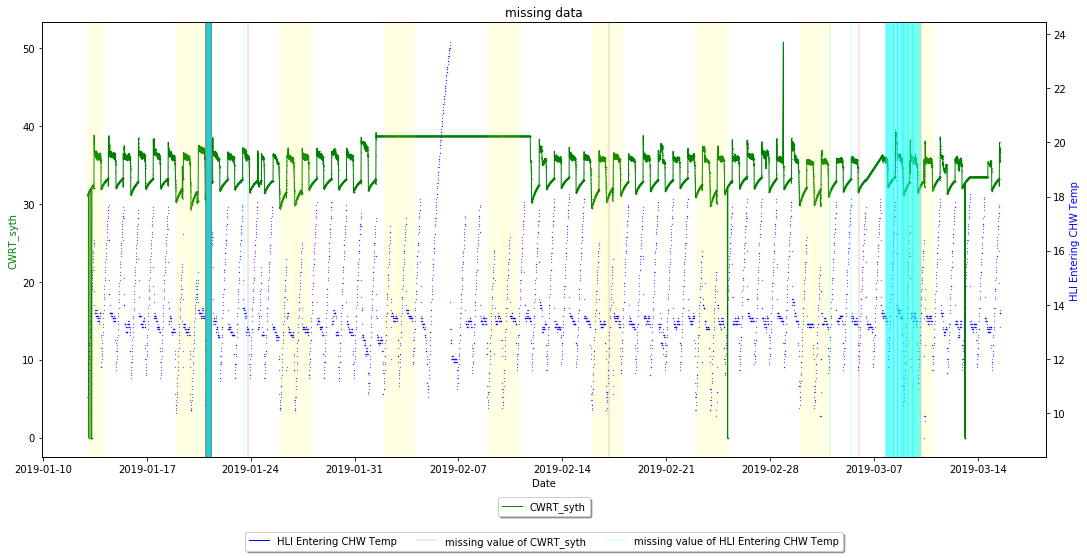

In [12]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    
# plot outliers
for col, clr in zip(maincols, ['brown', 'cyan']):
    ts_missing = list(data_2[data_2['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=0.6, color=clr, linewidth=0.4, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=0.6, linewidth=0.4, color=clr)
        i += 1

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.title('missing data')
plt.show()

## Add More Features

In [13]:
#data_2['year'] = data.index.year
#data_2['month'] = data.index.month
#data_2['day'] = data_2.index.day
data_2['weekday'] = data_2.index.weekday+1
data_2['hourminute'] = data_2.index.hour*60+data_2.index.minute
data_2.head()

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20


## <font color='purple'>Anomaly Type 2: Univariate Outliers</font>

In [14]:
def normalize_scores(pds_):
    pds = pds_.copy()
    pds_max = pds.max()
    pds_min = pds.min()
    return 100*(pds - pds_min).div(pds_max - pds_min)

def caldistancefromcenterrange(df_, c, pctilecut):
    # calculate the distance from median as outlier scores, any distance within [0, pctilecut] is 0
    df = df_[c].copy()
    c_median = df.median()
    tmp = abs(df - c_median)
    cutoff = np.nanpercentile(tmp, pctilecut)
    tmp[tmp<=cutoff] = 0
    return normalize_scores(tmp)
    

In [15]:
# calculate seperately for weekdays and weekend
wkd_ind = list(data_2[data_2['weekday']<6].index)
for c in maincols:
    data_2['Score_('+c+')_distanced'] = 0
    data_2.loc[data_2.index.isin(wkd_ind), 'Score_('+c+')_distanced'] = caldistancefromcenterrange(
        data_2[data_2.index.isin(wkd_ind)], c, 98)
    data_2.loc[~data_2.index.isin(wkd_ind), 'Score_('+c+')_distanced'] = caldistancefromcenterrange(
        data_2[~data_2.index.isin(wkd_ind)], c, 98)
    #data_2['Score_('+c+')_distanced'] = caldistancefromcenterrange(data_2, c, 98.8)
    

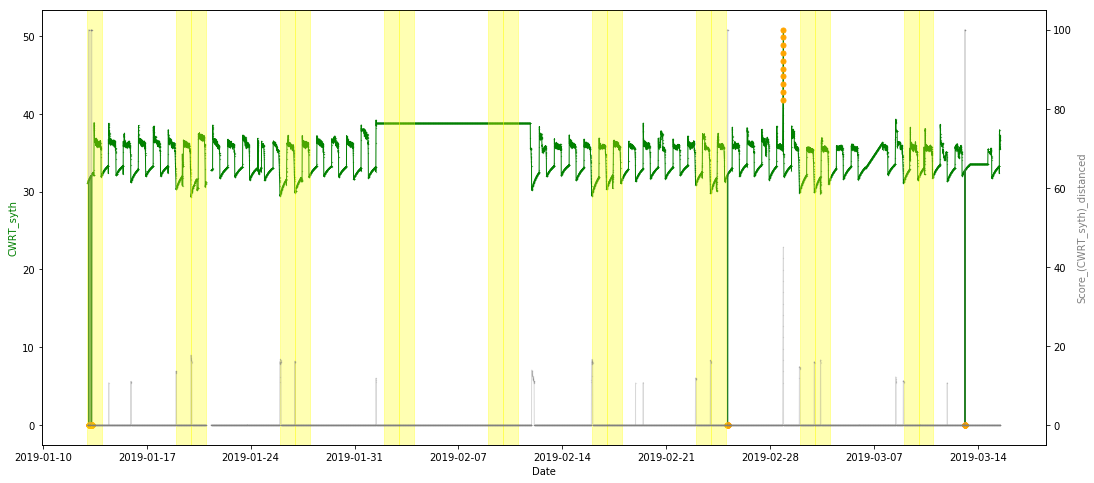

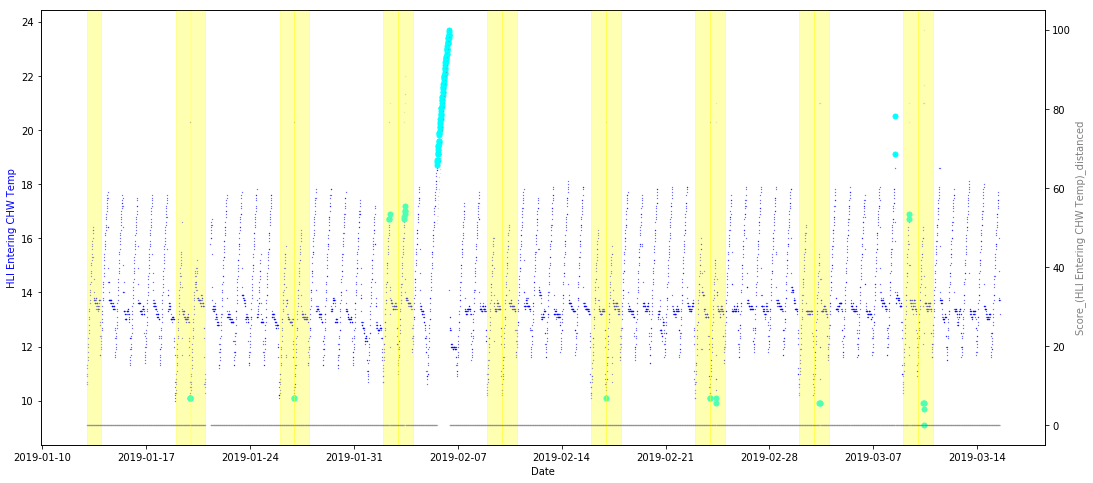

In [16]:
for c, clr in zip(maincols, [['g', 'orange'], ['b', 'cyan']]):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1))

    ax1.plot_date(data_2.index, data_2[c], c=clr[0], markersize=0.5, marker='.', linewidth=1, linestyle='-')
    tmp = data_2[data_2['Score_('+c+')_distanced']>18].copy()
    ax1.plot_date(tmp.index, tmp[c], c=clr[1], markersize=10, marker='.', linestyle='')
    ax1.set_ylabel(c, color=clr[0])
    ax1.set_xlabel('Date')
    
    ax2.plot_date(data_2.index, data_2['Score_('+c+')_distanced'], c='grey', 
                  markersize=0.5,  marker='.', linewidth=1, linestyle='-', alpha=0.3)
    ax2.set_ylabel('Score_('+c+')_distanced', color='grey')

    tmp = data_2.index.to_frame()
    tmp['wkday'] = data_2.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    plt.show()


## <font color='purple'>Anomaly Type 3: Univariate Daily Profile Inconsistency</font>
1. <font color='grey'>make sure no timestamp is missed</font>
2. <font color='grey'>replace single variate exteme values and missing values with mean of the similar time - data_2_modified</font>
3. <font color='grey'>cluster based on data_2_modified (data from 2), minority clusters is considered as outliers, obtain majority cluster, and use it to train and onderfitted model - further outlier detection.</font>

In [17]:
def replaceoutlier(df_, col, oulierlabel_cols=None, how='mean', timecols=['weekday', 'hourminute']):
    df = df_.copy()
    if oulierlabel_cols is None:
        oulierlabel_cols = ['LABEL_('+col+')_(extreme_value)', 'LABEL_('+col+')_(wrong_gap)']    
    condition_1 = (df[oulierlabel_cols]==False).sum(axis=1)==len(oulierlabel_cols)
    grp = df[condition_1].groupby(timecols)[col] #######
    if how=='mean':
        meanvals = grp.mean().to_frame()
    else:
        meanvals = grp.median().to_frame()
    meanvals.reset_index(inplace=True)
    meanvals = meanvals.rename(columns={col: 'replace_val'})
    df = df.merge(meanvals, on=timecols, how='left', left_index=True, right_index=False).set_index(df_.index)
    condition_2 = (df[oulierlabel_cols]==True).sum(axis=1)>0
    df.loc[condition_2, col] = df.loc[condition_2, 'replace_val'] 
    return df[col]

def fillwithmean(df_, grocol='weekday'):
    df = df_.copy()
    tmp = df.describe().T
    colstofill = list(tmp[tmp['count']<len(df)].index)
    grpmean = df.groupby(grocol)[colstofill].mean()
    replacevalcols = ['replace_'+c for c in list(grpmean)]
    grpmean.columns = replacevalcols
    grpmean.reset_index(inplace=True)
    df = df.merge(grpmean, how='left', on=grocol).set_index(df.index)
    for col in colstofill:
        df.loc[df[col].isna(), col] = df.loc[df[col].isna(), 'replace_'+col]
    return df.drop(replacevalcols, axis=1)

def stdnormalize(pds):
    m = pds.mean()
    st = pds.std()
    absmx = abs(pds).max()
    if st > 0:
        result = (pds-m).div(st)
    else:
        result = pds-m
    return result.replace(-np.inf, -absmx*100).replace(np.inf, absmx*100).replace(np.nan, m)


def findheadandtailnanindex(df_, cols):
    df = df_.copy()
    result = {}
    for col in cols:
        pds = df[col].copy()
        head_ind = list(pds[:pds[pds.notnull()].index[0]].index[:-1])
        tail_ind = list(pds[pds[pds.notnull()].index[-1]:].index[1:])
        result[col] = head_ind + tail_ind
    return result
    
    
# ---------------------------- Imputation -----------------------------
# when the time gap is between (1, 3] times of normal gap, interpolate; 
# when the time gap is between (3, 5] times of normal gap, replace with median;
# else leave it empty

def imputets(df_, medianvalues_ts, correct_timegap, imputecols, timecols):
    df = df_.copy()
    mingap = min(correct_timegap.values())
    # get head and tail nan index
    headtailnanind = findheadandtailnanindex(df, maincols)
    
    for col in imputecols:
        pds = df[col].copy()
        
        tmp = pds.dropna().sort_index(ascending=True).to_frame()
        timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
        tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
        tmp['periods_missed'] = tmp['gap']/mingap

        tmp = tmp[tmp['periods_missed']>1].copy()
        tmp['prev_dt'] = tmp.index.to_series() - tmp['gap'] + mingap

        tmp['dt_missed'] = None
        tmp.loc[tmp['prev_dt'].notna(), 'dt_missed'] = tmp[tmp['prev_dt'].notna()].apply(
                    lambda row: 
                    list(pd.date_range(str(row['prev_dt']), periods=int(row['periods_missed']-1), 
                                       freq=mingap)) 
                    if int(row['periods_missed']-1) > 0 else [row['prev_dt']], 
                    axis=1)

        tgap_morethan5 = tmp[tmp['gap']>5*correct_timegap[col]].copy()
        ts_leave = list(itertools.chain(*list(tgap_morethan5['dt_missed'])))
        df[col+'_leave_empty'] = False
        df.loc[df.index.isin(ts_leave), col+'_leave_empty']=True
        
        tgap_between3n5 = tmp[(tmp['gap']>3*correct_timegap[col]) & 
                              (tmp['gap']<=5*correct_timegap[col])].copy()
        ts_fillmedian = list(itertools.chain(*list(tgap_between3n5['dt_missed'])))
        df[col+'_fill_median'] = False
        df.loc[df.index.isin(ts_fillmedian+headtailnanind[col]), col+'_fill_median']=True

        # fill with median
        sub = df.loc[df[col+'_fill_median']==True, timecols].copy()
        df.loc[df[col+'_fill_median']==True, col] = sub.merge(medianvalues_ts[[col]+timecols], 
          on=timecols, how='left').set_index(sub.index)[col]
        
        # interpolate
        df.loc[:, col] = df.loc[:, col].interpolate(method='polynomial', order=1) 
        # leave blank
        df.loc[df[col+'_leave_empty']==True, col]=np.nan
    return df


#### Interpolation
1. replace all labelled outliers in previous steps with median of the similar time (weekday, hourminute) 
2. for continuous missing timestamp > 5: ignore; for continuous missing timestamp in [3, 5], replace with same time median; else linear interpolation

In [18]:
# replace exteme value outliers with median of the similar time (weekday, hourminute) 
# do for week days and weekends separately

data_2_modified = data_2.copy()
wknd_ind = data_2_modified[data_2_modified['weekday']>=6].index

Score_cutoff = 18

for col in maincols:
    data_2_modified['LABEL_('+col+')_(extreme_value)'] = False
    data_2_modified.loc[data_2_modified['Score_('+col+')_distanced']>Score_cutoff, 
                        'LABEL_('+col+')_(extreme_value)'] = True
    sub_wknd = data_2_modified[data_2_modified.index.isin(wknd_ind)].copy()
    sub_wknd[col] = replaceoutlier(sub_wknd, col, how='median', timecols=timecols)
    sub_weekd = data_2_modified[~data_2_modified.index.isin(wknd_ind)].copy()
    sub_weekd[col] = replaceoutlier(sub_weekd, col, how='median', timecols=timecols)
    data_2_modified = sub_wknd.append(sub_weekd)


data_2_modified = data_2_modified.sort_index(ascending=True)
print(data_2_modified.shape, data_2.shape, set(data_2.index==data_2_modified.index))
display(data_2_modified.head())    

(17719, 12) (17719, 10) {True}


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value)
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0,0.0,NaN,False,False
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5,0.0,NaN,False,False
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10,0.0,0.0,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15,0.0,NaN,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20,0.0,NaN,False,False


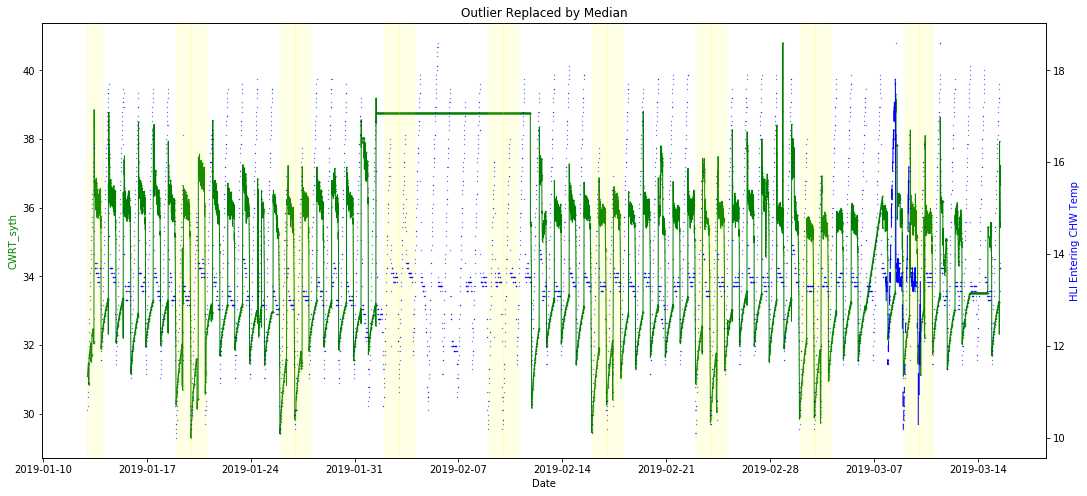

In [19]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified.index, data_2_modified['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='-')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified.index, data_2_modified['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='-')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified.index.to_frame()
tmp['wkday'] = data_2_modified.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')

plt.title('Outlier Replaced by Median')
plt.show()

In [20]:
# medianvalues_ts is used to impute the main dataset

medianvalues_ts = data_2_modified.groupby(timecols)[maincols].median()
medianvalues_ts.reset_index(inplace=True)

allmean = medianvalues_ts.groupby(['hourminute'])[maincols].mean().interpolate(method='polynomial', order=1)

for wkd in np.unique(medianvalues_ts['weekday']):
    # if the first and the last row has missing, then impute with overal mean: allmean
    sub = medianvalues_ts.loc[medianvalues_ts['weekday']==wkd, :].copy()
    sub_stas = sub.describe().T
    tmp_L = list(sub_stas[sub_stas['count'] < len(sub)].index)
    for scol in tmp_L:
        for x in [0, -1]:
            if np.isnan(sub[scol].iloc[x]):
                hourinfo = sub['hourminute'].iloc[x]
                medianvalues_ts.loc[
                    (medianvalues_ts['weekday']==wkd)&(medianvalues_ts.index==sub.index[x]),
                    scol] = allmean.loc[hourinfo, scol]
                
    # for others, impute by interpolation
    medianvalues_ts.loc[medianvalues_ts['weekday']==wkd, :] = medianvalues_ts.loc[
        medianvalues_ts['weekday']==wkd, :].interpolate(method='polynomial', order=1)            

# check and make sure no missing values in medianvalues_ts: !!!!!!!!! what if still missing?
display(medianvalues_ts.describe())
display(medianvalues_ts.head())
medianvalues_ts.to_csv('medianvalues_ts.csv', index=False)

,weekday,hourminute,CWRT_syth,HLI Entering CHW Temp
count,2016.000000,2016.000000,2016.000000,2016.000000
mean,4.000000,717.500000,34.176747,13.875521
std,2.000496,415.792824,1.909366,1.587211
min,1.000000,0.000000,30.141000,10.200000
25%,2.000000,358.750000,32.540001,13.150000
50%,4.000000,717.500000,33.310001,13.425000
75%,6.000000,1076.250000,36.022001,14.700000
max,7.000000,1435.000000,38.270000,18.600000


,weekday,hourminute,CWRT_syth,HLI Entering CHW Temp
0,1,0,32.200001,12.400001
1,1,5,32.220001,12.400001
2,1,10,32.220001,12.400001
3,1,15,32.249001,12.500000
4,1,20,32.265001,12.550000


In [21]:
# get correct time gaps
correct_timegap = {}
for col in maincols:
    tmp = data_2_modified[col].sort_index(ascending=True).dropna().to_frame()
    timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
    tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
    correct_timegap[col] = findcorrectgap(tmp, 0.7)

print(correct_timegap)   

{'CWRT_syth': Timedelta('0 days 00:05:00'), 'HLI Entering CHW Temp': Timedelta('0 days 00:15:00')}


In [22]:
# confirm no missing timestamp
pds = data_2_modified.index.to_series()
pds2 = pds.reindex(pd.date_range(start=pds.index[0], end=pds.index[-1], freq=min(correct_timegap.values())))
print(len(np.unique(pds.index)), len(np.unique(pds2.index)))


17719 17719


##### Impute the pre-cleaned (extreme outliers replaces with median)
- this will be used to find out cluster centroids

In [23]:
data_2_modified = imputets(data_2_modified, medianvalues_ts, correct_timegap, maincols, timecols)

print(data_2_modified.shape)
print(data_2_modified.dtypes)
print(min(data_2_modified.index), max(data_2_modified.index))
display(data_2_modified.head())

data_2_modified.to_csv('data_2_modified.csv')

(17719, 16)
Date                                              object
Time                                              object
CWRT_syth                                        float64
HLI Entering CHW Temp                            float64
LABEL_(CWRT_syth)_(wrong_gap)                       bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)           bool
weekday                                            int64
hourminute                                         int64
Score_(CWRT_syth)_distanced                      float64
Score_(HLI Entering CHW Temp)_distanced          float64
LABEL_(CWRT_syth)_(extreme_value)                   bool
LABEL_(HLI Entering CHW Temp)_(extreme_value)       bool
CWRT_syth_leave_empty                               bool
CWRT_syth_fill_median                               bool
HLI Entering CHW Temp_leave_empty                   bool
HLI Entering CHW Temp_fill_median                   bool
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,LABEL_(CWRT_syth)_(extreme_value),LABEL_(HLI Entering CHW Temp)_(extreme_value),CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,11.700000,False,False,7,0,0.0,NaN,False,False,False,False,False,True
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,11.125000,False,False,7,5,0.0,NaN,False,False,False,False,False,True
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.600000,False,False,7,10,0.0,0.0,False,False,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,10.633334,False,False,7,15,0.0,NaN,False,False,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,10.666667,False,False,7,20,0.0,NaN,False,False,False,False,False,False


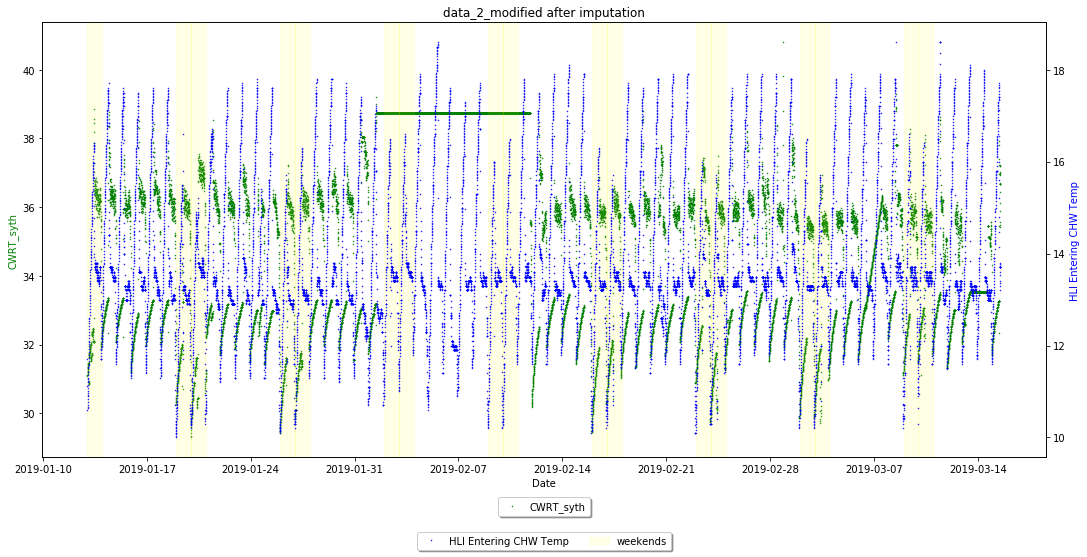

In [24]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_modified.index, data_2_modified['CWRT_syth'], 
              c='g', markersize=1, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_modified.index, data_2_modified['HLI Entering CHW Temp'], 
              c='b', markersize=1,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_modified.index.to_frame()
tmp['wkday'] = data_2_modified.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1
    
plt.title('data_2_modified after imputation')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


##### Impute the non-cleaned (no replacement of outliers)
- this will be used for daily profile scoring

In [25]:
data_2_impute = imputets(data_2, medianvalues_ts, correct_timegap, maincols, timecols)

print(data_2_impute.shape)
print(data_2_impute.dtypes)
print(min(data_2_impute.index), max(data_2_impute.index))
display(data_2_impute.head())


(17719, 14)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                   bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)       bool
weekday                                        int64
hourminute                                     int64
Score_(CWRT_syth)_distanced                  float64
Score_(HLI Entering CHW Temp)_distanced      float64
CWRT_syth_leave_empty                           bool
CWRT_syth_fill_median                           bool
HLI Entering CHW Temp_leave_empty               bool
HLI Entering CHW Temp_fill_median               bool
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,11.700000,False,False,7,0,0.0,NaN,False,False,False,True
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,11.125000,False,False,7,5,0.0,NaN,False,False,False,True
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.600000,False,False,7,10,0.0,0.0,False,False,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,10.633334,False,False,7,15,0.0,NaN,False,False,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,10.666667,False,False,7,20,0.0,NaN,False,False,False,False


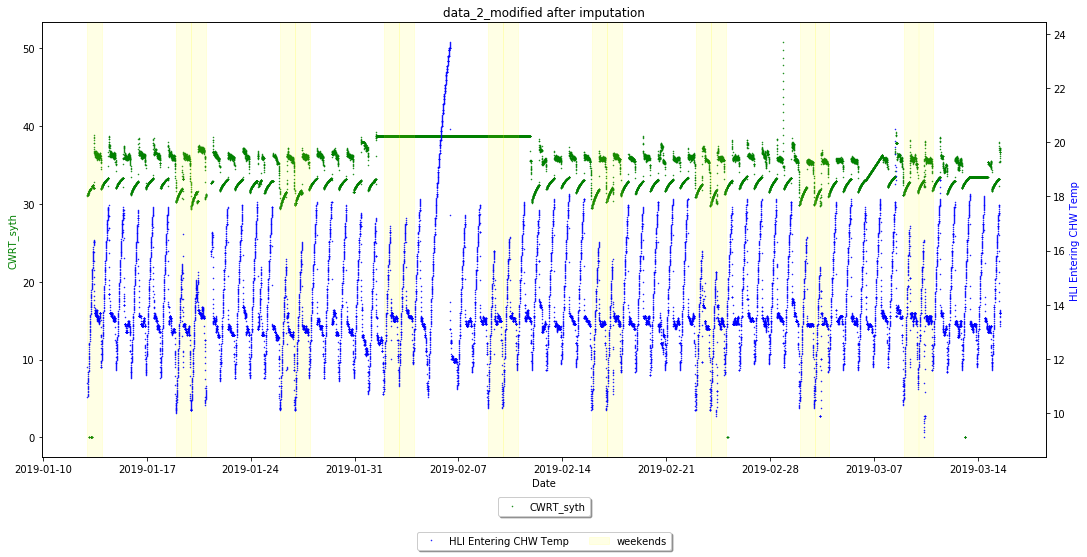

In [26]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_impute.index, data_2_impute['CWRT_syth'], 
              c='g', markersize=1, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_impute.index, data_2_impute['HLI Entering CHW Temp'], 
              c='b', markersize=1,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1
    
plt.title('data_2_modified after imputation')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


#### Clustering separately for weekdays and weekends
1. hierarchical clustering per column separately for weekdays and weekends
2. get the majority cluster and calculate centroid
3. calculate distance of each daily profile to the profile centroid of its own group
4. normalize the distance to [0, 100] and use as profile anomaly score

##### Find out centroids using data_2_modified

In [27]:
dfs = []
for col in maincols:
    # after previous imputation, there will still be nan left (continuous missing timegaps > 5), fillna with 0
    tmp = data_2_modified.pivot(index='Date', columns='hourminute', values=col).fillna(0) 
    tmp.columns = [col+'_'+str(c) for c in list(tmp)]
    dfs += [tmp]
dailypattern = pd.concat(dfs, axis=1)

display(dailypattern.head())

dailypattern_smry = dailypattern.describe().T
display(dailypattern_smry.head())

# remove the columns dailypattern where count is too few
# dropcols = list(dailypattern_smry[dailypattern_smry['count']<len(dailypattern)*0.5].index)
# print('drop columns:', len(dropcols))

# print(dailypattern.shape)
# dailypattern = dailypattern.drop(dropcols, axis=1)
print(dailypattern.shape)
display(dailypattern.head())

,CWRT_syth_0,CWRT_syth_5,CWRT_syth_10,CWRT_syth_15,CWRT_syth_20,CWRT_syth_25,CWRT_syth_30,CWRT_syth_35,CWRT_syth_40,CWRT_syth_45,CWRT_syth_50,CWRT_syth_55,CWRT_syth_60,CWRT_syth_65,CWRT_syth_70,CWRT_syth_75,CWRT_syth_80,CWRT_syth_85,CWRT_syth_90,CWRT_syth_95,CWRT_syth_100,CWRT_syth_105,CWRT_syth_110,CWRT_syth_115,CWRT_syth_120,CWRT_syth_125,CWRT_syth_130,CWRT_syth_135,CWRT_syth_140,CWRT_syth_145,CWRT_syth_150,CWRT_syth_155,CWRT_syth_160,CWRT_syth_165,CWRT_syth_170,CWRT_syth_175,CWRT_syth_180,CWRT_syth_185,CWRT_syth_190,CWRT_syth_195,CWRT_syth_200,CWRT_syth_205,CWRT_syth_210,CWRT_syth_215,CWRT_syth_220,CWRT_syth_225,CWRT_syth_230,CWRT_syth_235,CWRT_syth_240,CWRT_syth_245,CWRT_syth_250,CWRT_syth_255,CWRT_syth_260,CWRT_syth_265,CWRT_syth_270,CWRT_syth_275,CWRT_syth_280,CWRT_syth_285,CWRT_syth_290,CWRT_syth_295,CWRT_syth_300,CWRT_syth_305,CWRT_syth_310,CWRT_syth_315,CWRT_syth_320,CWRT_syth_325,CWRT_syth_330,CWRT_syth_335,CWRT_syth_340,CWRT_syth_345,CWRT_syth_350,CWRT_syth_355,CWRT_syth_360,CWRT_syth_365,CWRT_syth_370,CWRT_syth_375,CWRT_syth_380,CWRT_syth_385,CWRT_syth_390,CWRT_syth_395,CWRT_syth_400,CWRT_syth_405,CWRT_syth_410,CWRT_syth_415,CWRT_syth_420,CWRT_syth_425,CWRT_syth_430,CWRT_syth_435,CWRT_syth_440,CWRT_syth_445,CWRT_syth_450,CWRT_syth_455,CWRT_syth_460,CWRT_syth_465,CWRT_syth_470,CWRT_syth_475,CWRT_syth_480,CWRT_syth_485,CWRT_syth_490,CWRT_syth_495,CWRT_syth_500,CWRT_syth_505,CWRT_syth_510,CWRT_syth_515,CWRT_syth_520,CWRT_syth_525,CWRT_syth_530,CWRT_syth_535,CWRT_syth_540,CWRT_syth_545,CWRT_syth_550,CWRT_syth_555,CWRT_syth_560,CWRT_syth_565,CWRT_syth_570,CWRT_syth_575,CWRT_syth_580,CWRT_syth_585,CWRT_syth_590,CWRT_syth_595,CWRT_syth_600,CWRT_syth_605,CWRT_syth_610,CWRT_syth_615,CWRT_syth_620,CWRT_syth_625,CWRT_syth_630,CWRT_syth_635,CWRT_syth_640,CWRT_syth_645,CWRT_syth_650,CWRT_syth_655,CWRT_syth_660,CWRT_syth_665,CWRT_syth_670,CWRT_syth_675,CWRT_syth_680,CWRT_syth_685,CWRT_syth_690,CWRT_syth_695,CWRT_syth_700,CWRT_syth_705,CWRT_syth_710,CWRT_syth_715,CWRT_syth_720,CWRT_syth_725,CWRT_syth_730,CWRT_syth_735,CWRT_syth_740,CWRT_syth_745,CWRT_syth_750,CWRT_syth_755,CWRT_syth_760,CWRT_syth_765,CWRT_syth_770,CWRT_syth_775,CWRT_syth_780,CWRT_syth_785,CWRT_syth_790,CWRT_syth_795,CWRT_syth_800,CWRT_syth_805,CWRT_syth_810,CWRT_syth_815,CWRT_syth_820,CWRT_syth_825,CWRT_syth_830,CWRT_syth_835,CWRT_syth_840,CWRT_syth_845,CWRT_syth_850,CWRT_syth_855,CWRT_syth_860,CWRT_syth_865,CWRT_syth_870,CWRT_syth_875,CWRT_syth_880,CWRT_syth_885,CWRT_syth_890,CWRT_syth_895,CWRT_syth_900,CWRT_syth_905,CWRT_syth_910,CWRT_syth_915,CWRT_syth_920,CWRT_syth_925,CWRT_syth_930,CWRT_syth_935,CWRT_syth_940,CWRT_syth_945,CWRT_syth_950,CWRT_syth_955,CWRT_syth_960,CWRT_syth_965,CWRT_syth_970,CWRT_syth_975,CWRT_syth_980,CWRT_syth_985,CWRT_syth_990,CWRT_syth_995,CWRT_syth_1000,CWRT_syth_1005,CWRT_syth_1010,CWRT_syth_1015,CWRT_syth_1020,CWRT_syth_1025,CWRT_syth_1030,CWRT_syth_1035,CWRT_syth_1040,CWRT_syth_1045,CWRT_syth_1050,CWRT_syth_1055,CWRT_syth_1060,CWRT_syth_1065,CWRT_syth_1070,CWRT_syth_1075,CWRT_syth_1080,CWRT_syth_1085,CWRT_syth_1090,CWRT_syth_1095,CWRT_syth_1100,CWRT_syth_1105,CWRT_syth_1110,CWRT_syth_1115,CWRT_syth_1120,CWRT_syth_1125,CWRT_syth_1130,CWRT_syth_1135,CWRT_syth_1140,CWRT_syth_1145,CWRT_syth_1150,CWRT_syth_1155,CWRT_syth_1160,CWRT_syth_1165,CWRT_syth_1170,CWRT_syth_1175,CWRT_syth_1180,CWRT_syth_1185,CWRT_syth_1190,CWRT_syth_1195,CWRT_syth_1200,CWRT_syth_1205,CWRT_syth_1210,CWRT_syth_1215,CWRT_syth_1220,CWRT_syth_1225,CWRT_syth_1230,CWRT_syth_1235,CWRT_syth_1240,CWRT_syth_1245,CWRT_syth_1250,CWRT_syth_1255,CWRT_syth_1260,CWRT_syth_1265,CWRT_syth_1270,CWRT_syth_1275,CWRT_syth_1280,CWRT_syth_1285,CWRT_syth_1290,CWRT_syth_1295,CWRT_syth_1300,CWRT_syth_1305,CWRT_syth_1310,CWRT_syth_1315,CWRT_syth_1320,CWRT_syth_1325,CWRT_syth_1330,CWRT_syth_1335,CWRT_syth_1340,CWRT_syth_1345,CWRT_syth_1350,CWRT_syth_1355,CWRT_syth_1360,CWRT_syth_1365,CWRT_syth_1370,CWRT_syth_1375,CWRT_syth_1380,CWRT_syth_1385,CWRT_syth_1390,CWRT_syth_1395,CWRT_syth_1400,CWRT_s

,count,mean,std,min,25%,50%,75%,max
CWRT_syth_0,62.0,32.869742,2.749018,29.670000,31.6775,32.135000,32.410000,38.75
CWRT_syth_5,62.0,32.885774,2.740405,29.670000,31.7000,32.176000,32.410000,38.75
CWRT_syth_10,62.0,32.904694,2.732021,29.719999,31.7040,32.200001,32.430000,38.75
CWRT_syth_15,62.0,32.916984,2.725457,29.752000,31.7220,32.180000,32.459999,38.75
CWRT_syth_20,62.0,32.930274,2.718550,29.760000,31.7450,32.216001,32.471999,38.75


(62, 576)


,CWRT_syth_0,CWRT_syth_5,CWRT_syth_10,CWRT_syth_15,CWRT_syth_20,CWRT_syth_25,CWRT_syth_30,CWRT_syth_35,CWRT_syth_40,CWRT_syth_45,CWRT_syth_50,CWRT_syth_55,CWRT_syth_60,CWRT_syth_65,CWRT_syth_70,CWRT_syth_75,CWRT_syth_80,CWRT_syth_85,CWRT_syth_90,CWRT_syth_95,CWRT_syth_100,CWRT_syth_105,CWRT_syth_110,CWRT_syth_115,CWRT_syth_120,CWRT_syth_125,CWRT_syth_130,CWRT_syth_135,CWRT_syth_140,CWRT_syth_145,CWRT_syth_150,CWRT_syth_155,CWRT_syth_160,CWRT_syth_165,CWRT_syth_170,CWRT_syth_175,CWRT_syth_180,CWRT_syth_185,CWRT_syth_190,CWRT_syth_195,CWRT_syth_200,CWRT_syth_205,CWRT_syth_210,CWRT_syth_215,CWRT_syth_220,CWRT_syth_225,CWRT_syth_230,CWRT_syth_235,CWRT_syth_240,CWRT_syth_245,CWRT_syth_250,CWRT_syth_255,CWRT_syth_260,CWRT_syth_265,CWRT_syth_270,CWRT_syth_275,CWRT_syth_280,CWRT_syth_285,CWRT_syth_290,CWRT_syth_295,CWRT_syth_300,CWRT_syth_305,CWRT_syth_310,CWRT_syth_315,CWRT_syth_320,CWRT_syth_325,CWRT_syth_330,CWRT_syth_335,CWRT_syth_340,CWRT_syth_345,CWRT_syth_350,CWRT_syth_355,CWRT_syth_360,CWRT_syth_365,CWRT_syth_370,CWRT_syth_375,CWRT_syth_380,CWRT_syth_385,CWRT_syth_390,CWRT_syth_395,CWRT_syth_400,CWRT_syth_405,CWRT_syth_410,CWRT_syth_415,CWRT_syth_420,CWRT_syth_425,CWRT_syth_430,CWRT_syth_435,CWRT_syth_440,CWRT_syth_445,CWRT_syth_450,CWRT_syth_455,CWRT_syth_460,CWRT_syth_465,CWRT_syth_470,CWRT_syth_475,CWRT_syth_480,CWRT_syth_485,CWRT_syth_490,CWRT_syth_495,CWRT_syth_500,CWRT_syth_505,CWRT_syth_510,CWRT_syth_515,CWRT_syth_520,CWRT_syth_525,CWRT_syth_530,CWRT_syth_535,CWRT_syth_540,CWRT_syth_545,CWRT_syth_550,CWRT_syth_555,CWRT_syth_560,CWRT_syth_565,CWRT_syth_570,CWRT_syth_575,CWRT_syth_580,CWRT_syth_585,CWRT_syth_590,CWRT_syth_595,CWRT_syth_600,CWRT_syth_605,CWRT_syth_610,CWRT_syth_615,CWRT_syth_620,CWRT_syth_625,CWRT_syth_630,CWRT_syth_635,CWRT_syth_640,CWRT_syth_645,CWRT_syth_650,CWRT_syth_655,CWRT_syth_660,CWRT_syth_665,CWRT_syth_670,CWRT_syth_675,CWRT_syth_680,CWRT_syth_685,CWRT_syth_690,CWRT_syth_695,CWRT_syth_700,CWRT_syth_705,CWRT_syth_710,CWRT_syth_715,CWRT_syth_720,CWRT_syth_725,CWRT_syth_730,CWRT_syth_735,CWRT_syth_740,CWRT_syth_745,CWRT_syth_750,CWRT_syth_755,CWRT_syth_760,CWRT_syth_765,CWRT_syth_770,CWRT_syth_775,CWRT_syth_780,CWRT_syth_785,CWRT_syth_790,CWRT_syth_795,CWRT_syth_800,CWRT_syth_805,CWRT_syth_810,CWRT_syth_815,CWRT_syth_820,CWRT_syth_825,CWRT_syth_830,CWRT_syth_835,CWRT_syth_840,CWRT_syth_845,CWRT_syth_850,CWRT_syth_855,CWRT_syth_860,CWRT_syth_865,CWRT_syth_870,CWRT_syth_875,CWRT_syth_880,CWRT_syth_885,CWRT_syth_890,CWRT_syth_895,CWRT_syth_900,CWRT_syth_905,CWRT_syth_910,CWRT_syth_915,CWRT_syth_920,CWRT_syth_925,CWRT_syth_930,CWRT_syth_935,CWRT_syth_940,CWRT_syth_945,CWRT_syth_950,CWRT_syth_955,CWRT_syth_960,CWRT_syth_965,CWRT_syth_970,CWRT_syth_975,CWRT_syth_980,CWRT_syth_985,CWRT_syth_990,CWRT_syth_995,CWRT_syth_1000,CWRT_syth_1005,CWRT_syth_1010,CWRT_syth_1015,CWRT_syth_1020,CWRT_syth_1025,CWRT_syth_1030,CWRT_syth_1035,CWRT_syth_1040,CWRT_syth_1045,CWRT_syth_1050,CWRT_syth_1055,CWRT_syth_1060,CWRT_syth_1065,CWRT_syth_1070,CWRT_syth_1075,CWRT_syth_1080,CWRT_syth_1085,CWRT_syth_1090,CWRT_syth_1095,CWRT_syth_1100,CWRT_syth_1105,CWRT_syth_1110,CWRT_syth_1115,CWRT_syth_1120,CWRT_syth_1125,CWRT_syth_1130,CWRT_syth_1135,CWRT_syth_1140,CWRT_syth_1145,CWRT_syth_1150,CWRT_syth_1155,CWRT_syth_1160,CWRT_syth_1165,CWRT_syth_1170,CWRT_syth_1175,CWRT_syth_1180,CWRT_syth_1185,CWRT_syth_1190,CWRT_syth_1195,CWRT_syth_1200,CWRT_syth_1205,CWRT_syth_1210,CWRT_syth_1215,CWRT_syth_1220,CWRT_syth_1225,CWRT_syth_1230,CWRT_syth_1235,CWRT_syth_1240,CWRT_syth_1245,CWRT_syth_1250,CWRT_syth_1255,CWRT_syth_1260,CWRT_syth_1265,CWRT_syth_1270,CWRT_syth_1275,CWRT_syth_1280,CWRT_syth_1285,CWRT_syth_1290,CWRT_syth_1295,CWRT_syth_1300,CWRT_syth_1305,CWRT_syth_1310,CWRT_syth_1315,CWRT_syth_1320,CWRT_syth_1325,CWRT_syth_1330,CWRT_syth_1335,CWRT_syth_1340,CWRT_syth_1345,CWRT_syth_1350,CWRT_syth_1355,CWRT_syth_1360,CWRT_syth_1365,CWRT_syth_1370,CWRT_syth_1375,CWRT_syth_1380,CWRT_syth_1385,CWRT_syth_1390,CWRT_syth_1395,CWRT_syth_1400,CWRT_s

In [28]:
# clustering separately for weekdays and weekends

dailypattern.index = list(dailypattern.index.to_series().apply(
    lambda x: pd.datetime.strptime(x, '%Y-%m-%d')))
dailypattern['weekday'] = dailypattern.index.weekday+1

dailypattern_weekdays = dailypattern[dailypattern['weekday']<6].copy()
dailypattern_weekends = dailypattern[dailypattern['weekday']>=6].copy()

print(dailypattern_weekdays.shape, dailypattern_weekends.shape)
display(set(dailypattern_weekdays.describe().T['count']))
display(set(dailypattern_weekends.describe().T['count']))


(45, 577) (17, 577)


{45.0}

{17.0}

In [29]:
# ------------------- weekdays --------------------

def dmf(u, v):
    result, _ = fastdtw(u, v, dist=euclidean)
    return result

def getcluster(dailypattern_df, col, clustercol, nclusters):
    time0 = time.time()
    tmp = dailypattern_df[[c for c in list(dailypattern_df) if col in c]].copy()
    linked = linkage(tmp.values, method='single', metric=dmf)  #  metric=dmf  or  'euclidean'
    dailypattern_df[clustercol] = fcluster(linked, nclusters, 'maxclust')
    print('total time used', time.time()-time0)
    return dailypattern_df

for col in maincols:
    print(col+' (weekdays): ------------')
    dailypattern_weekdays = getcluster(dailypattern_weekdays, col, '('+col+')_weekday_cluster', 5)
    display(dailypattern_weekdays['('+col+')_weekday_cluster'].value_counts(ascending=True))

    print(col+' (weekends): ------------')
    dailypattern_weekends = getcluster(dailypattern_weekends, col, '('+col+')_weekend_cluster', 3)
    display(dailypattern_weekends['('+col+')_weekend_cluster'].value_counts(ascending=True))


CWRT_syth (weekdays): ------------
total time used 100.43751406669617


3     1
4     1
5     1
1     6
2    36
Name: (CWRT_syth)_weekday_cluster, dtype: int64

CWRT_syth (weekends): ------------
total time used 12.571834802627563


3     1
1     4
2    12
Name: (CWRT_syth)_weekend_cluster, dtype: int64

HLI Entering CHW Temp (weekdays): ------------
total time used 102.62699294090271


2     1
3     1
4     1
5     1
1    41
Name: (HLI Entering CHW Temp)_weekday_cluster, dtype: int64

HLI Entering CHW Temp (weekends): ------------
total time used 11.943681716918945


2     1
3     1
1    15
Name: (HLI Entering CHW Temp)_weekend_cluster, dtype: int64

In [30]:
# get centroids (using cleaned and imputed data)
centroids = {}

for col in maincols:
    majorcluster_wd = dailypattern_weekdays['('+col+')_weekday_cluster'].value_counts(ascending=False).index[0]
    majorcluster_wk = dailypattern_weekends['('+col+')_weekend_cluster'].value_counts(ascending=False).index[0]
    centroids['('+col+')_weekday'] = dailypattern_weekdays[
        dailypattern_weekdays['('+col+')_weekday_cluster']==majorcluster_wd].mean(axis=0)
    centroids['('+col+')_weekend'] = dailypattern_weekends[
        dailypattern_weekends['('+col+')_weekend_cluster']==majorcluster_wk].mean(axis=0)


##### Calculate distance to centroid using data_2_impute

In [31]:
dfs = []
for col in maincols:
    # after previous imputation, there will still be nan left (continuous missing timegaps > 5), fillna with 0
    tmp = data_2_impute.pivot(index='Date', columns='hourminute', values=col).fillna(0) 
    tmp.columns = [col+'_'+str(c) for c in list(tmp)]
    dfs += [tmp]
dailypattern_noclean = pd.concat(dfs, axis=1)

display(dailypattern_noclean.head())

dailypattern_smry_noclean = dailypattern_noclean.describe().T
display(dailypattern_smry_noclean.head())

# remove the columns dailypattern where count is too few
# dropcols = list(dailypattern_smry_noclean[dailypattern_smry_noclean['count']<len(dailypattern_noclean)*0.5].index)
# print('drop columns:', len(dropcols))

# print(dailypattern_noclean.shape)
# dailypattern_noclean = dailypattern_noclean.drop(dropcols, axis=1)
print(dailypattern_noclean.shape)
display(dailypattern_noclean.head())


,CWRT_syth_0,CWRT_syth_5,CWRT_syth_10,CWRT_syth_15,CWRT_syth_20,CWRT_syth_25,CWRT_syth_30,CWRT_syth_35,CWRT_syth_40,CWRT_syth_45,CWRT_syth_50,CWRT_syth_55,CWRT_syth_60,CWRT_syth_65,CWRT_syth_70,CWRT_syth_75,CWRT_syth_80,CWRT_syth_85,CWRT_syth_90,CWRT_syth_95,CWRT_syth_100,CWRT_syth_105,CWRT_syth_110,CWRT_syth_115,CWRT_syth_120,CWRT_syth_125,CWRT_syth_130,CWRT_syth_135,CWRT_syth_140,CWRT_syth_145,CWRT_syth_150,CWRT_syth_155,CWRT_syth_160,CWRT_syth_165,CWRT_syth_170,CWRT_syth_175,CWRT_syth_180,CWRT_syth_185,CWRT_syth_190,CWRT_syth_195,CWRT_syth_200,CWRT_syth_205,CWRT_syth_210,CWRT_syth_215,CWRT_syth_220,CWRT_syth_225,CWRT_syth_230,CWRT_syth_235,CWRT_syth_240,CWRT_syth_245,CWRT_syth_250,CWRT_syth_255,CWRT_syth_260,CWRT_syth_265,CWRT_syth_270,CWRT_syth_275,CWRT_syth_280,CWRT_syth_285,CWRT_syth_290,CWRT_syth_295,CWRT_syth_300,CWRT_syth_305,CWRT_syth_310,CWRT_syth_315,CWRT_syth_320,CWRT_syth_325,CWRT_syth_330,CWRT_syth_335,CWRT_syth_340,CWRT_syth_345,CWRT_syth_350,CWRT_syth_355,CWRT_syth_360,CWRT_syth_365,CWRT_syth_370,CWRT_syth_375,CWRT_syth_380,CWRT_syth_385,CWRT_syth_390,CWRT_syth_395,CWRT_syth_400,CWRT_syth_405,CWRT_syth_410,CWRT_syth_415,CWRT_syth_420,CWRT_syth_425,CWRT_syth_430,CWRT_syth_435,CWRT_syth_440,CWRT_syth_445,CWRT_syth_450,CWRT_syth_455,CWRT_syth_460,CWRT_syth_465,CWRT_syth_470,CWRT_syth_475,CWRT_syth_480,CWRT_syth_485,CWRT_syth_490,CWRT_syth_495,CWRT_syth_500,CWRT_syth_505,CWRT_syth_510,CWRT_syth_515,CWRT_syth_520,CWRT_syth_525,CWRT_syth_530,CWRT_syth_535,CWRT_syth_540,CWRT_syth_545,CWRT_syth_550,CWRT_syth_555,CWRT_syth_560,CWRT_syth_565,CWRT_syth_570,CWRT_syth_575,CWRT_syth_580,CWRT_syth_585,CWRT_syth_590,CWRT_syth_595,CWRT_syth_600,CWRT_syth_605,CWRT_syth_610,CWRT_syth_615,CWRT_syth_620,CWRT_syth_625,CWRT_syth_630,CWRT_syth_635,CWRT_syth_640,CWRT_syth_645,CWRT_syth_650,CWRT_syth_655,CWRT_syth_660,CWRT_syth_665,CWRT_syth_670,CWRT_syth_675,CWRT_syth_680,CWRT_syth_685,CWRT_syth_690,CWRT_syth_695,CWRT_syth_700,CWRT_syth_705,CWRT_syth_710,CWRT_syth_715,CWRT_syth_720,CWRT_syth_725,CWRT_syth_730,CWRT_syth_735,CWRT_syth_740,CWRT_syth_745,CWRT_syth_750,CWRT_syth_755,CWRT_syth_760,CWRT_syth_765,CWRT_syth_770,CWRT_syth_775,CWRT_syth_780,CWRT_syth_785,CWRT_syth_790,CWRT_syth_795,CWRT_syth_800,CWRT_syth_805,CWRT_syth_810,CWRT_syth_815,CWRT_syth_820,CWRT_syth_825,CWRT_syth_830,CWRT_syth_835,CWRT_syth_840,CWRT_syth_845,CWRT_syth_850,CWRT_syth_855,CWRT_syth_860,CWRT_syth_865,CWRT_syth_870,CWRT_syth_875,CWRT_syth_880,CWRT_syth_885,CWRT_syth_890,CWRT_syth_895,CWRT_syth_900,CWRT_syth_905,CWRT_syth_910,CWRT_syth_915,CWRT_syth_920,CWRT_syth_925,CWRT_syth_930,CWRT_syth_935,CWRT_syth_940,CWRT_syth_945,CWRT_syth_950,CWRT_syth_955,CWRT_syth_960,CWRT_syth_965,CWRT_syth_970,CWRT_syth_975,CWRT_syth_980,CWRT_syth_985,CWRT_syth_990,CWRT_syth_995,CWRT_syth_1000,CWRT_syth_1005,CWRT_syth_1010,CWRT_syth_1015,CWRT_syth_1020,CWRT_syth_1025,CWRT_syth_1030,CWRT_syth_1035,CWRT_syth_1040,CWRT_syth_1045,CWRT_syth_1050,CWRT_syth_1055,CWRT_syth_1060,CWRT_syth_1065,CWRT_syth_1070,CWRT_syth_1075,CWRT_syth_1080,CWRT_syth_1085,CWRT_syth_1090,CWRT_syth_1095,CWRT_syth_1100,CWRT_syth_1105,CWRT_syth_1110,CWRT_syth_1115,CWRT_syth_1120,CWRT_syth_1125,CWRT_syth_1130,CWRT_syth_1135,CWRT_syth_1140,CWRT_syth_1145,CWRT_syth_1150,CWRT_syth_1155,CWRT_syth_1160,CWRT_syth_1165,CWRT_syth_1170,CWRT_syth_1175,CWRT_syth_1180,CWRT_syth_1185,CWRT_syth_1190,CWRT_syth_1195,CWRT_syth_1200,CWRT_syth_1205,CWRT_syth_1210,CWRT_syth_1215,CWRT_syth_1220,CWRT_syth_1225,CWRT_syth_1230,CWRT_syth_1235,CWRT_syth_1240,CWRT_syth_1245,CWRT_syth_1250,CWRT_syth_1255,CWRT_syth_1260,CWRT_syth_1265,CWRT_syth_1270,CWRT_syth_1275,CWRT_syth_1280,CWRT_syth_1285,CWRT_syth_1290,CWRT_syth_1295,CWRT_syth_1300,CWRT_syth_1305,CWRT_syth_1310,CWRT_syth_1315,CWRT_syth_1320,CWRT_syth_1325,CWRT_syth_1330,CWRT_syth_1335,CWRT_syth_1340,CWRT_syth_1345,CWRT_syth_1350,CWRT_syth_1355,CWRT_syth_1360,CWRT_syth_1365,CWRT_syth_1370,CWRT_syth_1375,CWRT_syth_1380,CWRT_syth_1385,CWRT_syth_1390,CWRT_syth_1395,CWRT_syth_1400,CWRT_s

,count,mean,std,min,25%,50%,75%,max
CWRT_syth_0,62.0,32.350387,4.998739,0.0,31.5550,32.090,32.410000,38.75
CWRT_syth_5,62.0,32.366097,4.995713,0.0,31.5745,32.135,32.410000,38.75
CWRT_syth_10,62.0,32.380258,4.993338,0.0,31.6045,32.135,32.430000,38.75
CWRT_syth_15,62.0,32.396839,4.990848,0.0,31.6265,32.135,32.459999,38.75
CWRT_syth_20,62.0,32.409871,4.988496,0.0,31.6325,32.180,32.471999,38.75


(62, 576)


,CWRT_syth_0,CWRT_syth_5,CWRT_syth_10,CWRT_syth_15,CWRT_syth_20,CWRT_syth_25,CWRT_syth_30,CWRT_syth_35,CWRT_syth_40,CWRT_syth_45,CWRT_syth_50,CWRT_syth_55,CWRT_syth_60,CWRT_syth_65,CWRT_syth_70,CWRT_syth_75,CWRT_syth_80,CWRT_syth_85,CWRT_syth_90,CWRT_syth_95,CWRT_syth_100,CWRT_syth_105,CWRT_syth_110,CWRT_syth_115,CWRT_syth_120,CWRT_syth_125,CWRT_syth_130,CWRT_syth_135,CWRT_syth_140,CWRT_syth_145,CWRT_syth_150,CWRT_syth_155,CWRT_syth_160,CWRT_syth_165,CWRT_syth_170,CWRT_syth_175,CWRT_syth_180,CWRT_syth_185,CWRT_syth_190,CWRT_syth_195,CWRT_syth_200,CWRT_syth_205,CWRT_syth_210,CWRT_syth_215,CWRT_syth_220,CWRT_syth_225,CWRT_syth_230,CWRT_syth_235,CWRT_syth_240,CWRT_syth_245,CWRT_syth_250,CWRT_syth_255,CWRT_syth_260,CWRT_syth_265,CWRT_syth_270,CWRT_syth_275,CWRT_syth_280,CWRT_syth_285,CWRT_syth_290,CWRT_syth_295,CWRT_syth_300,CWRT_syth_305,CWRT_syth_310,CWRT_syth_315,CWRT_syth_320,CWRT_syth_325,CWRT_syth_330,CWRT_syth_335,CWRT_syth_340,CWRT_syth_345,CWRT_syth_350,CWRT_syth_355,CWRT_syth_360,CWRT_syth_365,CWRT_syth_370,CWRT_syth_375,CWRT_syth_380,CWRT_syth_385,CWRT_syth_390,CWRT_syth_395,CWRT_syth_400,CWRT_syth_405,CWRT_syth_410,CWRT_syth_415,CWRT_syth_420,CWRT_syth_425,CWRT_syth_430,CWRT_syth_435,CWRT_syth_440,CWRT_syth_445,CWRT_syth_450,CWRT_syth_455,CWRT_syth_460,CWRT_syth_465,CWRT_syth_470,CWRT_syth_475,CWRT_syth_480,CWRT_syth_485,CWRT_syth_490,CWRT_syth_495,CWRT_syth_500,CWRT_syth_505,CWRT_syth_510,CWRT_syth_515,CWRT_syth_520,CWRT_syth_525,CWRT_syth_530,CWRT_syth_535,CWRT_syth_540,CWRT_syth_545,CWRT_syth_550,CWRT_syth_555,CWRT_syth_560,CWRT_syth_565,CWRT_syth_570,CWRT_syth_575,CWRT_syth_580,CWRT_syth_585,CWRT_syth_590,CWRT_syth_595,CWRT_syth_600,CWRT_syth_605,CWRT_syth_610,CWRT_syth_615,CWRT_syth_620,CWRT_syth_625,CWRT_syth_630,CWRT_syth_635,CWRT_syth_640,CWRT_syth_645,CWRT_syth_650,CWRT_syth_655,CWRT_syth_660,CWRT_syth_665,CWRT_syth_670,CWRT_syth_675,CWRT_syth_680,CWRT_syth_685,CWRT_syth_690,CWRT_syth_695,CWRT_syth_700,CWRT_syth_705,CWRT_syth_710,CWRT_syth_715,CWRT_syth_720,CWRT_syth_725,CWRT_syth_730,CWRT_syth_735,CWRT_syth_740,CWRT_syth_745,CWRT_syth_750,CWRT_syth_755,CWRT_syth_760,CWRT_syth_765,CWRT_syth_770,CWRT_syth_775,CWRT_syth_780,CWRT_syth_785,CWRT_syth_790,CWRT_syth_795,CWRT_syth_800,CWRT_syth_805,CWRT_syth_810,CWRT_syth_815,CWRT_syth_820,CWRT_syth_825,CWRT_syth_830,CWRT_syth_835,CWRT_syth_840,CWRT_syth_845,CWRT_syth_850,CWRT_syth_855,CWRT_syth_860,CWRT_syth_865,CWRT_syth_870,CWRT_syth_875,CWRT_syth_880,CWRT_syth_885,CWRT_syth_890,CWRT_syth_895,CWRT_syth_900,CWRT_syth_905,CWRT_syth_910,CWRT_syth_915,CWRT_syth_920,CWRT_syth_925,CWRT_syth_930,CWRT_syth_935,CWRT_syth_940,CWRT_syth_945,CWRT_syth_950,CWRT_syth_955,CWRT_syth_960,CWRT_syth_965,CWRT_syth_970,CWRT_syth_975,CWRT_syth_980,CWRT_syth_985,CWRT_syth_990,CWRT_syth_995,CWRT_syth_1000,CWRT_syth_1005,CWRT_syth_1010,CWRT_syth_1015,CWRT_syth_1020,CWRT_syth_1025,CWRT_syth_1030,CWRT_syth_1035,CWRT_syth_1040,CWRT_syth_1045,CWRT_syth_1050,CWRT_syth_1055,CWRT_syth_1060,CWRT_syth_1065,CWRT_syth_1070,CWRT_syth_1075,CWRT_syth_1080,CWRT_syth_1085,CWRT_syth_1090,CWRT_syth_1095,CWRT_syth_1100,CWRT_syth_1105,CWRT_syth_1110,CWRT_syth_1115,CWRT_syth_1120,CWRT_syth_1125,CWRT_syth_1130,CWRT_syth_1135,CWRT_syth_1140,CWRT_syth_1145,CWRT_syth_1150,CWRT_syth_1155,CWRT_syth_1160,CWRT_syth_1165,CWRT_syth_1170,CWRT_syth_1175,CWRT_syth_1180,CWRT_syth_1185,CWRT_syth_1190,CWRT_syth_1195,CWRT_syth_1200,CWRT_syth_1205,CWRT_syth_1210,CWRT_syth_1215,CWRT_syth_1220,CWRT_syth_1225,CWRT_syth_1230,CWRT_syth_1235,CWRT_syth_1240,CWRT_syth_1245,CWRT_syth_1250,CWRT_syth_1255,CWRT_syth_1260,CWRT_syth_1265,CWRT_syth_1270,CWRT_syth_1275,CWRT_syth_1280,CWRT_syth_1285,CWRT_syth_1290,CWRT_syth_1295,CWRT_syth_1300,CWRT_syth_1305,CWRT_syth_1310,CWRT_syth_1315,CWRT_syth_1320,CWRT_syth_1325,CWRT_syth_1330,CWRT_syth_1335,CWRT_syth_1340,CWRT_syth_1345,CWRT_syth_1350,CWRT_syth_1355,CWRT_syth_1360,CWRT_syth_1365,CWRT_syth_1370,CWRT_syth_1375,CWRT_syth_1380,CWRT_syth_1385,CWRT_syth_1390,CWRT_syth_1395,CWRT_syth_1400,CWRT_s

In [32]:
# calculate distance (per maincol) to its own major centroid (using uncleaned imputed data)
# clustering separately for weekdays and weekends

dailypattern_noclean.index = list(dailypattern_noclean.index.to_series().apply(
    lambda x: pd.datetime.strptime(x, '%Y-%m-%d')))
dailypattern_noclean['weekday'] = dailypattern_noclean.index.weekday+1

dailypattern_noclean_weekdays = dailypattern_noclean[dailypattern_noclean['weekday']<6].copy()
dailypattern_noclean_weekends = dailypattern_noclean[dailypattern_noclean['weekday']>=6].copy()

print(dailypattern_noclean_weekdays.shape, dailypattern_noclean_weekends.shape)
display(set(dailypattern_noclean_weekdays.describe().T['count']))
display(set(dailypattern_noclean_weekends.describe().T['count']))


(45, 577) (17, 577)


{45.0}

{17.0}

In [33]:
for col in maincols:
    cols = [c for c in list(dailypattern_noclean_weekdays) if (col in c) and ('cluster' not in c)]
    dailypattern_noclean_weekdays['('+col+')_distance'] = [
        dmf(dailypattern_noclean_weekdays[cols].iloc[i, :], centroids['('+col+')_weekday'][cols]) 
        for i in range(len(dailypattern_noclean_weekdays))]
    dailypattern_noclean_weekends['('+col+')_distance'] = [
        dmf(dailypattern_noclean_weekends[cols].iloc[i, :], centroids['('+col+')_weekend'][cols]) 
        for i in range(len(dailypattern_noclean_weekends))]    


In [34]:
# add score to data_2
cols = ['(CWRT_syth)_distance','(HLI Entering CHW Temp)_distance']
dailyprofilescores_noclean = dailypattern_noclean_weekdays[cols].append(dailypattern_noclean_weekends[cols])
dailyprofilescores_noclean = dailyprofilescores_noclean.rename(
    columns={k: 'Score_'+k.replace('distance', 'cluster') for k in list(dailyprofilescores_noclean)})

print(data_2.shape)
data_2 = data_2.merge(dailyprofilescores_noclean, how='left', left_on=data_2['Date'], 
                      right_on=dailyprofilescores_noclean.index.astype(str)).set_index(
    data_2.index).drop('key_0', axis=1)

print(data_2.shape)
display(data_2.head())

(17719, 10)
(17719, 12)


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0,0.0,NaN,893.571816,46.604126
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5,0.0,NaN,893.571816,46.604126
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10,0.0,0.0,893.571816,46.604126
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15,0.0,NaN,893.571816,46.604126
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20,0.0,NaN,893.571816,46.604126


In [35]:
# remove scores of the first and the last day if they are shorter than 1 day
for k in [str(min(data_2.index).date()), str(max(data_2.index).date())]:
    if len(data_2[data_2['Date']==k]) < 288:
        for col in maincols:
            data_2.loc[data_2['Date']==k, 'Score_('+col+')_cluster'] = np.nan

# normalize score
for col in maincols:
    data_2['Score_('+col+')_cluster'] = normalize_scores(data_2['Score_('+col+')_cluster'])

display(data_2[[c for c in list(data_2) if 'Score' in c]].describe())
data_2.to_csv('data_2.csv', index=True)

,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster
count,17615.000000,5868.000000,17568.000000,17568.000000
mean,0.422026,1.481149,11.043301,5.973006
std,5.160662,10.806613,19.247590,18.262006
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750721,0.710433
50%,0.000000,0.000000,1.364830,1.562910
75%,0.000000,0.000000,7.998246,3.013914
max,100.000000,100.000000,100.000000,100.000000


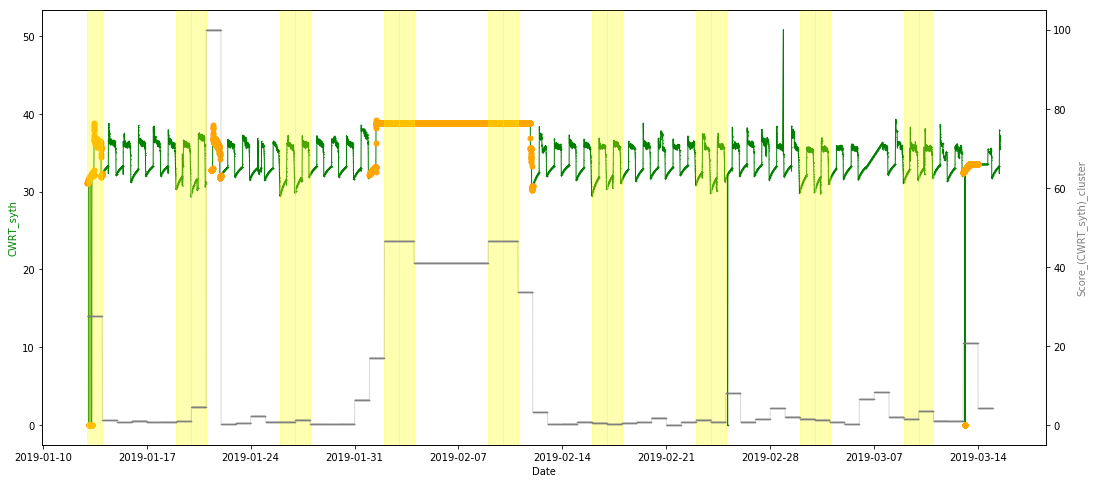

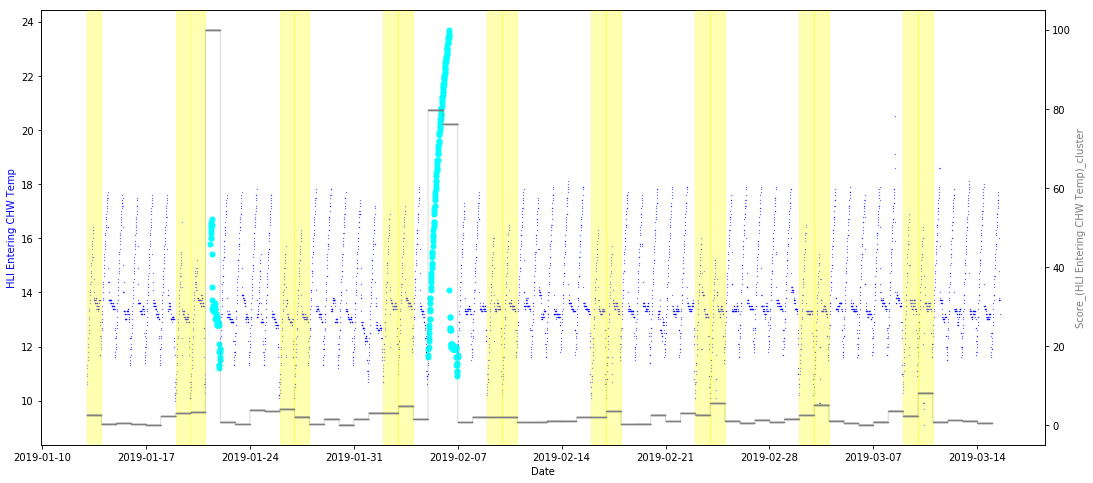

In [36]:
for c, clr in zip(maincols, [['g', 'orange'], ['b', 'cyan']]):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1))

    ax1.plot_date(data_2.index, data_2[c], c=clr[0], markersize=0.5, marker='.', linewidth=1, linestyle='-')
    tmp = data_2[data_2['Score_('+c+')_cluster']>10].copy()
    ax1.plot_date(tmp.index, tmp[c], c=clr[1], markersize=10, marker='.', linestyle='')
    ax1.set_ylabel(c, color=clr[0])
    ax1.set_xlabel('Date')
    
    ax2.plot_date(data_2.index, data_2['Score_('+c+')_cluster'], c='grey', 
                  markersize=0.5,  marker='.', linewidth=1, linestyle='-', alpha=0.3)
    ax2.set_ylabel('Score_('+c+')_cluster', color='grey')

    tmp = data_2.index.to_frame()
    tmp['wkday'] = data_2.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    plt.show()


## <font color='purple'>Anomaly Type 4: Multivariate / Univariate timestamp value anomaly</font>
1. <font color='grey'>make sure no timestamp is missed</font>
2. <font color='grey'>train autoencoder on pre-cleaned data</font>

<font color='orange'>__*Assumption*__</font>: <font color='brown'>__high energy wastage anomaly__ and __inefficient equipment operation anomaly__ are minorities, and a predictor fitted to majority data can flag out the minorities</font>


In [37]:
data_2_clean = data_2.copy()
scorecut_dist = 18
scorecut_cluster = 10

for col in maincols:
    data_2_clean[col+'_outlier'] = False
    data_2_clean.loc[data_2_clean['Score_('+col+')_distanced']>scorecut_dist, col+'_outlier'] = True

for col in maincols:
    data_2_clean[col] = replaceoutlier(
        data_2_clean, col, oulierlabel_cols=[col+'_outlier'], how='median', timecols=timecols)
    data_2_clean.loc[data_2_clean['Score_('+col+')_cluster']>scorecut_cluster, col] = np.nan
    
data_2_clean = imputets(data_2_clean, medianvalues_ts, correct_timegap, maincols, timecols)[maincols+timecols]

print(min(data_2_clean.index), max(data_2_clean.index))
print(data_2_clean.shape)
display(data_2_clean.head())
display(data_2_clean.describe())

data_2_clean.to_csv('data_2_clean.csv', index=True)

2019-01-13 00:00:00 2019-03-15 12:30:00
(17719, 4)


,CWRT_syth,HLI Entering CHW Temp,weekday,hourminute
2019-01-13 00:00:00,30.490000,11.700000,7,0
2019-01-13 00:05:00,30.506000,11.125000,7,5
2019-01-13 00:10:00,30.530001,10.600000,7,10
2019-01-13 00:15:00,30.546000,10.633334,7,15
2019-01-13 00:20:00,30.590000,10.666667,7,20


,CWRT_syth,HLI Entering CHW Temp,weekday,hourminute
count,13975.000000,16834.000000,17719.000000,17719.000000
mean,34.038801,13.834866,3.959761,714.581240
std,1.972290,1.600629,2.005443,415.609241
min,29.298001,10.000000,1.000000,0.000000
25%,32.459999,13.000000,2.000000,355.000000
50%,33.400002,13.466667,4.000000,710.000000
75%,35.884001,14.666667,6.000000,1075.000000
max,40.804002,18.600000,7.000000,1435.000000


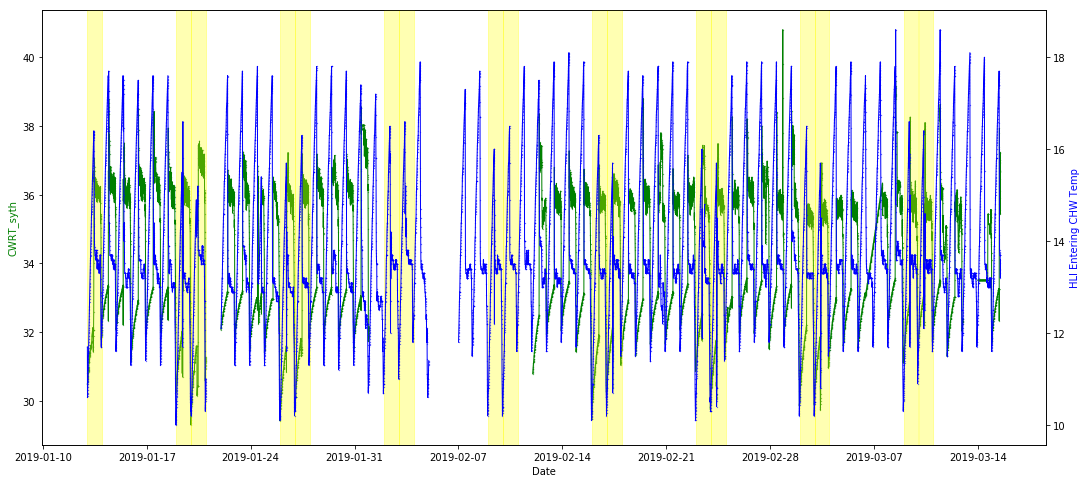

In [38]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

for c, ax_, clr in zip(maincols, [ax1, ax2], ['g', 'b']):
    ax_.plot_date(data_2_clean.index, data_2_clean[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=1, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2_clean.index.to_frame()
tmp['wkday'] = data_2_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
plt.show()


In [43]:
# padding
windowsize = int(3*60/5)
startt = min(data_2.index)
endt = max(data_2.index)
tgap = min(correct_timegap.values())

dfhead = pd.DataFrame([], columns=list(data_2), index=[startt - tgap*i for i in range(1, windowsize)])
dfhead['weekday'] = dfhead.index.weekday+1
dfhead['hourminute'] = dfhead.index.hour*60+dfhead.index.minute
dftail = pd.DataFrame([], columns=list(data_2), index=[endt + tgap*i for i in range(1, windowsize)])
dftail['weekday'] = dftail.index.weekday+1
dftail['hourminute'] = dftail.index.hour*60+dfhead.index.minute

data_2_pad = dfhead.append(data_2).append(dftail).sort_index(ascending=True)

display(data_2_pad.head(50))
display(data_2_pad.tail(50))


data_2_impute = imputets(data_2_pad, medianvalues_ts, correct_timegap, maincols, timecols)

print(data_2_impute.shape)
print(data_2_impute.dtypes)
print(min(data_2_impute.index), max(data_2_impute.index))
display(data_2_impute.head())

data_2_impute.to_csv('data_2_impute.csv', index=True)

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster
2019-01-12 21:05:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1265,NaN,NaN,NaN,NaN
2019-01-12 21:10:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1270,NaN,NaN,NaN,NaN
2019-01-12 21:15:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1275,NaN,NaN,NaN,NaN
2019-01-12 21:20:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1280,NaN,NaN,NaN,NaN
2019-01-12 21:25:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1285,NaN,NaN,NaN,NaN
2019-01-12 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1290,NaN,NaN,NaN,NaN
2019-01-12 21:35:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1295,NaN,NaN,NaN,NaN
2019-01-12 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1300,NaN,NaN,NaN,NaN
2019-01-12 21:45:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1305,NaN,NaN,NaN,NaN
2019-01-12 21:50:00,NaN,NaN,NaN,NaN,NaN,NaN,6,1310,NaN,NaN,NaN,NaN


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster
2019-03-15 11:20:00,2019-03-15,1120h,36.668000,NaN,False,False,5,680,0.0,NaN,NaN,NaN
2019-03-15 11:25:00,2019-03-15,1125h,36.668000,NaN,False,False,5,685,0.0,NaN,NaN,NaN
2019-03-15 11:30:00,2019-03-15,1130h,36.678000,13.7,False,False,5,690,0.0,0.0,NaN,NaN
2019-03-15 11:35:00,2019-03-15,1135h,37.203999,NaN,False,False,5,695,0.0,NaN,NaN,NaN
2019-03-15 11:40:00,2019-03-15,1140h,37.236001,NaN,False,False,5,700,0.0,NaN,NaN,NaN
2019-03-15 11:45:00,2019-03-15,1145h,36.678000,13.7,False,False,5,705,0.0,0.0,NaN,NaN
2019-03-15 11:50:00,2019-03-15,1150h,37.024000,NaN,False,False,5,710,0.0,NaN,NaN,NaN
2019-03-15 11:55:00,2019-03-15,1155h,36.446000,NaN,False,False,5,715,0.0,NaN,NaN,NaN
2019-03-15 12:00:00,2019-03-15,1200h,36.119999,13.7,False,False,5,720,0.0,0.0,NaN,NaN
2019-03-15 12:05:00,2019-03-15,1205h,35.902001,NaN,False,False,5,725,0.0,NaN,NaN,NaN


(17789, 16)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                 object
LABEL_(HLI Entering CHW Temp)_(wrong_gap)     object
weekday                                        int64
hourminute                                     int64
Score_(CWRT_syth)_distanced                  float64
Score_(HLI Entering CHW Temp)_distanced      float64
Score_(CWRT_syth)_cluster                    float64
Score_(HLI Entering CHW Temp)_cluster        float64
CWRT_syth_leave_empty                           bool
CWRT_syth_fill_median                           bool
HLI Entering CHW Temp_leave_empty               bool
HLI Entering CHW Temp_fill_median               bool
dtype: object
2019-01-12 21:05:00 2019-03-15 15:25:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median
2019-01-12 21:05:00,NaN,NaN,35.709999,13.300000,NaN,NaN,6,1265,NaN,NaN,NaN,NaN,False,True,False,True
2019-01-12 21:10:00,NaN,NaN,35.641001,13.200000,NaN,NaN,6,1270,NaN,NaN,NaN,NaN,False,True,False,True
2019-01-12 21:15:00,NaN,NaN,35.536000,12.983333,NaN,NaN,6,1275,NaN,NaN,NaN,NaN,False,True,False,True
2019-01-12 21:20:00,NaN,NaN,35.425000,12.766667,NaN,NaN,6,1280,NaN,NaN,NaN,NaN,False,True,False,True
2019-01-12 21:25:00,NaN,NaN,35.328000,12.550000,NaN,NaN,6,1285,NaN,NaN,NaN,NaN,False,True,False,True


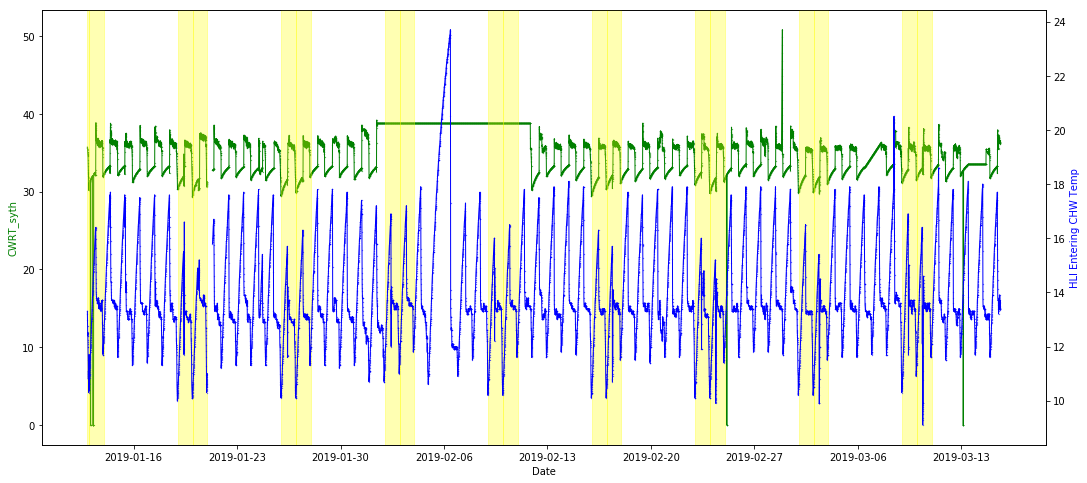

In [44]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

for c, ax_, clr in zip(maincols, [ax1, ax2], ['g', 'b']):
    ax_.plot_date(data_2_impute.index, data_2_impute[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=1, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
plt.show()
